# WOfS Validation_Data-Clean  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ga_ls8c_wofs_2_summary ](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_summary)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat 8 Collection 2 surface reflectance and shows surface water detected in Africa.
Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

The data in a WOFL is stored as a bit field. This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc). In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 
For more information on the structure of WOFLs and how to interact with them, see [Water Observations from Space](../Datasets/Water_Observations_from_Space.ipynb) and [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebooks. 

## Description
This notebook explains how you can compile tables from Collect Earth Online tool from each partner institution and make them analysis-ready for WOfS analysis and accuracy assessment. 

The notebook demonstrates how to:

1. Load collected validation points as a list of observations each has a location and month
2. Data wrangling including cleaning the table, and mapping each point two twelve month observation 

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages

In [2]:
%matplotlib inline

import time 
import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from rasterio.mask import mask
from sklearn.metrics import plot_confusion_matrix, f1_score 
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from deafrica_plotting import map_shapefile,display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_dask import create_local_dask_cluster

#for parallelisation 
from multiprocessing import Pool, Manager
import multiprocessing as mp
from tqdm import tqdm

### Connect to the datacube

In [3]:
dc = datacube.Datacube()

### Preprocessing 

In [25]:
#joining dataframes together and extract one csv for each partner institution 
DF = glob.glob('../Supplementary_data/Validation/Refined/Continent/*.csv')
frame = []
for d in DF: 
    f = pd.read_csv(d,delimiter=",")
    frame.append(f)
out = pd.concat(frame)
#out

In [26]:
out.columns

Index(['Unnamed: 0', 'PLOT_ID', 'LON', 'LAT', 'CLASS', 'MONTH', 'ACTUAL',
       'CLASS_WET', 'CLEAR_OBS', 'PREDICTION', 'geometry'],
      dtype='object')

In [27]:
out = out.drop(['Unnamed: 0'], axis=1)

In [28]:
out[0:30]

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLEAR_OBS,PREDICTION,geometry
0,137387037.0,29.875854,2.178788,Open water - freshwater,1,1,1.0,1.0,1,POINT (29.87585377 2.178788329)
1,137387037.0,29.875854,2.178788,Open water - freshwater,2,1,1.0,2.0,1,POINT (29.87585377 2.178788329)
2,137387037.0,29.875854,2.178788,Open water - freshwater,3,1,1.0,2.0,1,POINT (29.87585377 2.178788329)
3,137387037.0,29.875854,2.178788,Open water - freshwater,5,1,1.0,4.0,1,POINT (29.87585377 2.178788329)
4,137387037.0,29.875854,2.178788,Open water - freshwater,6,1,1.0,2.0,1,POINT (29.87585377 2.178788329)
5,137387037.0,29.875854,2.178788,Open water - freshwater,7,1,0.0,1.0,0,POINT (29.87585377 2.178788329)
6,137387037.0,29.875854,2.178788,Open water - freshwater,10,1,0.0,1.0,0,POINT (29.87585377 2.178788329)
7,137387038.0,27.272168,0.893874,Open water - freshwater,1,1,1.0,2.0,1,POINT (27.27216754 0.89387444)
8,137387038.0,27.272168,0.893874,Open water - freshwater,2,1,1.0,1.0,1,POINT (27.27216754 0.89387444)
9,137387038.0,27.272168,0.893874,Open water - freshwater,3,1,1.0,1.0,1,POINT (27.27216754 0.89387444)


In [29]:
out.to_csv('../Supplementary_data/Validation/Refined/Continent/Africa_validation_inland.csv')

### Analysis

In [20]:
#Read the ground truth data following analysis step 
CEO = '../Supplementary_data/Validation/Refined/Continent/Africa_validation_inland.csv'
# CEO = '../Supplementary_data/Validation/Refined/AFRIGIST/Groundtruth_AfriGIST_W305m.csv'
df = pd.read_csv(CEO,delimiter=",")

In [21]:
df.columns

Index(['Unnamed: 0', 'PLOT_ID', 'LON', 'LAT', 'CLASS', 'MONTH', 'ACTUAL',
       'CLASS_WET', 'CLEAR_OBS', 'PREDICTION', 'geometry'],
      dtype='object')

In [22]:
input_data=df.drop(['Unnamed: 0'], axis=1)

In [23]:
geometry = [Point(xy) for xy in zip(input_data.LON, input_data.LAT)]
crs = {'init': 'epsg:4326'} 
ValPoints = GeoDataFrame(input_data, crs=crs, geometry=geometry)

In [24]:
#Reading the boundary file for African countries 
aez = '../Supplementary_data/Validation/Refined/Continent/shapefile/AEZs_simple_IndianOcean.shp'

In [25]:
outline = gpd.read_file(aez).to_crs('EPSG:4326')
#outline

In [26]:
#Clipping the input data with the buffer zone to have all inland points that are not coastal 
include_points = gpd.clip(ValPoints, outline)

In [27]:
include_points.to_csv(('../Supplementary_data/Validation/Refined/Continent/Validation_IndianOceanZone.csv'))

In [28]:
#RCMRD_inland
confusion_matrix = pd.crosstab(include_points['ACTUAL'],include_points['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
confusion_matrix

PREDICTION,0,1,All
ACTUAL,,,
0,1491,261,1752
1,330,4581,4911
All,1821,4842,6663


In [29]:
confusion_matrix["User's"] = [confusion_matrix.loc[0][0] / confusion_matrix.loc[0]['All'] * 100, confusion_matrix.loc[1][1] / confusion_matrix.loc[1]['All'] *100, np.nan]
confusion_matrix

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,1491,261,1752,85.102740
1,330,4581,4911,93.280391
All,1821,4842,6663,NaN


In [30]:
producers_accuracy = pd.Series([confusion_matrix[0][0] / confusion_matrix[0]['All'] * 100,
                                confusion_matrix[1][1] / confusion_matrix[1]['All'] * 100]).rename("Producer's")

confusion_matrix = confusion_matrix.append(producers_accuracy)
confusion_matrix 

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,1491.000000,261.000000,1752.0,85.102740
1,330.000000,4581.000000,4911.0,93.280391
All,1821.000000,4842.000000,6663.0,NaN
Producer's,81.878089,94.609665,NaN,NaN


In [31]:
confusion_matrix.loc["Producer's", "User's"] = (confusion_matrix[0][0] + confusion_matrix[1][1]) / confusion_matrix['All']['All'] * 100
confusion_matrix

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,1491.000000,261.000000,1752.0,85.102740
1,330.000000,4581.000000,4911.0,93.280391
All,1821.000000,4842.000000,6663.0,NaN
Producer's,81.878089,94.609665,NaN,91.130122


In [32]:
fscore = pd.Series([(2*(confusion_matrix.loc[0]["User's"]*confusion_matrix.loc["Producer's"][0]) / (confusion_matrix.loc[0]["User's"] + confusion_matrix.loc["Producer's"][0])) / 100,
                   f1_score(include_points['ACTUAL'],include_points['PREDICTION'])]).rename("F-score")
confusion_matrix = confusion_matrix.append(fscore)

In [33]:
confusion_matrix

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,1491.000000,261.000000,1752.0,85.102740
1,330.000000,4581.000000,4911.0,93.280391
All,1821.000000,4842.000000,6663.0,NaN
Producer's,81.878089,94.609665,NaN,91.130122
F-score,0.834593,0.939403,NaN,NaN


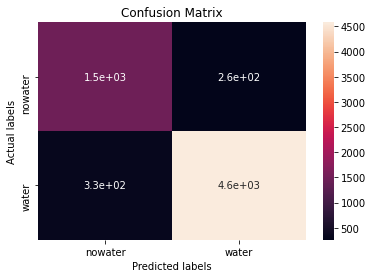

In [34]:
confusion_matrix = pd.crosstab(include_points['ACTUAL'],include_points['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'])
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot = True) #true to annotate cells 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['nowater','water']); ax.yaxis.set_ticklabels(['nowater','water']);
plt.show()

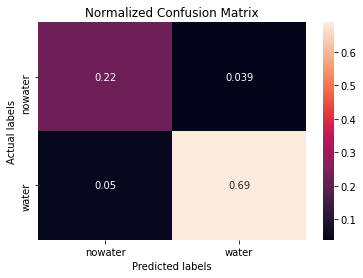

In [35]:
confusion_matrix = pd.crosstab(include_points['ACTUAL'],include_points['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'],normalize=True)
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot = True) #true to annotate cells 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(['nowater','water']); ax.yaxis.set_ticklabels(['nowater','water']);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)